# Deep Learning
## Assignment 3

Previously in Assignment 2, you trained a logistic regression and a neural network model.

The goal of this assignment us to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later, Make sure you can import them
# before proceeding further
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from six.moves import cPickle as pickle

First reload the data we generated in Assignment1

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [11]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size*image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [13]:
def accuracy(predictions, labels):
    return (100.0*np.sum(np.argmax(predictions,1)==np.argmax(labels,1))/predictions.shape[0])

## Problem 1
 Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using ```nn.l2_loss(t)```. The right amount of regularization should improve your validation / test accuracy

### Multinomial Logistic Regression with L2 Regularization

Initialized
Loss at step 0: 328.082092
Training accuracy: 4.7%
Validation accuracy: 8.4%
.........................
Loss at step 500: 1.245300
Training accuracy: 71.9%
Validation accuracy: 76.2%
.........................
Loss at step 1000: 1.014668
Training accuracy: 79.7%
Validation accuracy: 73.3%
.........................
Loss at step 1500: 0.975665
Training accuracy: 82.0%
Validation accuracy: 75.8%
.........................
Loss at step 2000: 1.001103
Training accuracy: 78.1%
Validation accuracy: 71.8%
.........................
Loss at step 2500: 1.169974
Training accuracy: 75.0%
Validation accuracy: 73.6%
.........................
Loss at step 3000: 1.155380
Training accuracy: 75.8%
Validation accuracy: 76.1%
.........................
test accuracy: 83.5%


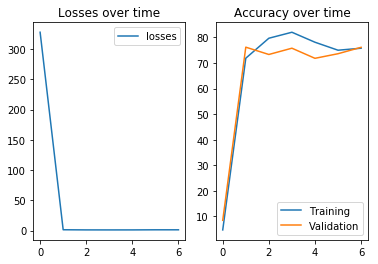

In [20]:
train_subset = 10000
num_steps = 3001
batch_size = 128
losses, train_acc, valid_acc = [],[],[]
beta = 0.1

graph = tf.Graph()
with graph.as_default():
    # Input data for the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights)+biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
    
    # Add regularizer
    loss = tf.reduce_mean(loss + beta * tf.nn.l2_loss(weights))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights)+biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights)+biases)

     

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step*batch_size)%(train_labels.shape[0]-batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step%500==0):
            losses.append(l)
            print('Loss at step %d: %f' % (step,l))
            acc = accuracy(predictions, batch_labels)
            train_acc.append(acc)
            print('Training accuracy: %0.1f%%' % acc)
            # calling .eval() on valid_prediction is basically like calling run(), but 
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            acc= accuracy(valid_prediction.eval(), valid_labels)
            valid_acc.append(acc)
            print('Validation accuracy: %.1f%%' % acc)
            print('.'*25)
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(),test_labels))

plt.subplot(1,2,1)
plt.plot(losses)
plt.legend(['losses'])
plt.title('Losses over time')
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy over time')
plt.legend(['Training', 'Validation'])
plt.show()

### Neural Network With L2 Regularization

Initialized
Loss at step 0: 31784.216797
Training accuracy: 9.4%
Validation accuracy: 39.6%
.........................
Loss at step 500: 1.542243
Training accuracy: 73.4%
Validation accuracy: 75.5%
.........................
Loss at step 1000: 1.355833
Training accuracy: 82.8%
Validation accuracy: 71.2%
.........................
Loss at step 1500: 1.346074
Training accuracy: 80.5%
Validation accuracy: 75.6%
.........................
Loss at step 2000: 1.309182
Training accuracy: 79.7%
Validation accuracy: 74.9%
.........................
Loss at step 2500: 1.434183
Training accuracy: 74.2%
Validation accuracy: 74.0%
.........................
Loss at step 3000: 1.475214
Training accuracy: 78.1%
Validation accuracy: 75.5%
.........................
test accuracy: 83.2%


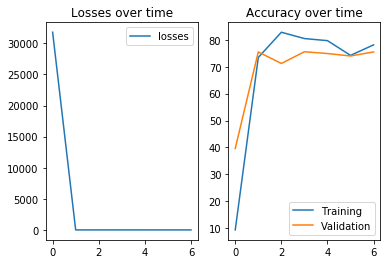

In [23]:
train_subset = 10000
num_steps = 3001
batch_size = 128
beta = 0.1
num_nodes = 1024
losses, train_acc, valid_acc = [],[],[]


graph = tf.Graph()
with graph.as_default():
    # Input data for the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training ReLU layer.
    logits_1 = tf.matmul(tf_train_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits_2))    
    loss = tf.reduce_mean(loss + beta * (tf.nn.l2_loss(weights_1)+tf.nn.l2_loss(weights_2)))
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training data.
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation data.
    logits_1 = tf.matmul(tf_valid_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test data.
    logits_1 = tf.matmul(tf_test_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    test_prediction = tf.nn.softmax(logits_2)
     

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step*batch_size)%(train_labels.shape[0]-batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step%500==0):
            losses.append(l)
            print('Loss at step %d: %f' % (step,l))
            acc = accuracy(predictions, batch_labels)
            train_acc.append(acc)
            print('Training accuracy: %0.1f%%' % acc)
            acc= accuracy(valid_prediction.eval(), valid_labels)
            valid_acc.append(acc)
            print('Validation accuracy: %.1f%%' % acc)
            print('.'*25)
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(),test_labels))

plt.subplot(1,2,1)
plt.plot(losses)
plt.legend(['losses'])
plt.title('Losses over time')
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy over time')
plt.legend(['Training', 'Validation'])
plt.show()

## Problem 2
Let's demonstrate an extreme cases of overfitting. Restrict your training data to just a few batches. What happens?

Initialized
Loss at step 0: 31731.730469
Training accuracy: 15.6%
Validation accuracy: 21.6%
.........................
Loss at step 500: 1.318784
Training accuracy: 83.6%
Validation accuracy: 74.0%
.........................
Loss at step 1000: 1.291716
Training accuracy: 88.3%
Validation accuracy: 74.1%
.........................
Loss at step 1500: 1.269603
Training accuracy: 91.4%
Validation accuracy: 76.4%
.........................
Loss at step 2000: 1.311118
Training accuracy: 87.5%
Validation accuracy: 76.3%
.........................
Loss at step 2500: 1.317634
Training accuracy: 85.9%
Validation accuracy: 74.0%
.........................
Loss at step 3000: 1.276788
Training accuracy: 89.1%
Validation accuracy: 75.1%
.........................
test accuracy: 82.1%


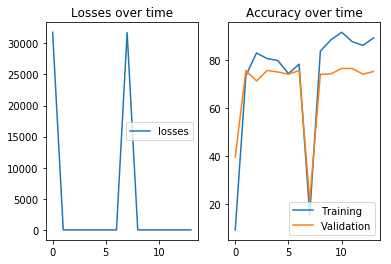

In [25]:
small_batch = 500
train_dataset_2 = train_dataset[:small_batch,:]
train_labels_2 = train_labels[:small_batch]

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step*batch_size)%(train_labels_2.shape[0]-batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_2[offset:(offset+batch_size), :]
        batch_labels = train_labels_2[offset:(offset+batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step%500==0):
            losses.append(l)
            print('Loss at step %d: %f' % (step,l))
            acc = accuracy(predictions, batch_labels)
            train_acc.append(acc)
            print('Training accuracy: %0.1f%%' % acc)
            acc= accuracy(valid_prediction.eval(), valid_labels)
            valid_acc.append(acc)
            print('Validation accuracy: %.1f%%' % acc)
            print('.'*25)
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(),test_labels))

plt.subplot(1,2,1)
plt.plot(losses)
plt.legend(['losses'])
plt.title('Losses over time')
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy over time')
plt.legend(['Training', 'Validation'])
plt.show()

## Problem 3
Introduce Dropout on the hidden layer of the nwural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides ```nn.dropout()``` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

Initialized
Loss at step 0: 31962.050781
Training accuracy: 14.1%
Validation accuracy: 20.6%
.........................
Loss at step 500: 1.616975
Training accuracy: 68.8%
Validation accuracy: 74.2%
.........................
Loss at step 1000: 1.386608
Training accuracy: 79.7%
Validation accuracy: 71.7%
.........................
Loss at step 1500: 1.390910
Training accuracy: 82.0%
Validation accuracy: 75.5%
.........................
Loss at step 2000: 1.380911
Training accuracy: 78.9%
Validation accuracy: 75.8%
.........................
Loss at step 2500: 1.525310
Training accuracy: 72.7%
Validation accuracy: 73.5%
.........................
Loss at step 3000: 1.541025
Training accuracy: 75.8%
Validation accuracy: 75.4%
.........................
test accuracy: 83.1%


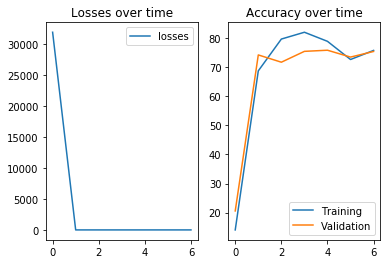

In [38]:
train_subset = 10000
num_steps = 3001
batch_size = 128
beta = 0.1
num_nodes = 1024
losses, train_acc, valid_acc = [],[],[]


graph = tf.Graph()
with graph.as_default():
    # Input data for the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training ReLU layer.
    logits_1 = tf.matmul(tf_train_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    # Dropout on hidden layer: ReLU layer
    keep_prob = tf.placeholder(tf.float32)
    relu_layer_dropout = tf.nn.dropout(relu_layer, 0.5)
    
    logits_2 = tf.matmul(relu_layer_dropout, weights_2)+biases_2
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits_2))    
    loss = tf.reduce_mean(loss + beta * (tf.nn.l2_loss(weights_1)+tf.nn.l2_loss(weights_2)))
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training data.
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation data.
    logits_1 = tf.matmul(tf_valid_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test data.
    logits_1 = tf.matmul(tf_test_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    test_prediction = tf.nn.softmax(logits_2)
     

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step*batch_size)%(train_labels.shape[0]-batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step%500==0):
            losses.append(l)
            print('Loss at step %d: %f' % (step,l))
            acc = accuracy(predictions, batch_labels)
            train_acc.append(acc)
            print('Training accuracy: %0.1f%%' % acc)
            acc= accuracy(valid_prediction.eval(), valid_labels)
            valid_acc.append(acc)
            print('Validation accuracy: %.1f%%' % acc)
            print('.'*25)
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(),test_labels))

plt.subplot(1,2,1)
plt.plot(losses)
plt.legend(['losses'])
plt.title('Losses over time')
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy over time')
plt.legend(['Training', 'Validation'])
plt.show()

## Problem 4

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%].

One avenue you can explore is to add multiple layers.

Another one us to use learning rate decay:
```Python
    global_step = tf.Variable(0) # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_steps, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).Mminize(loss, global_step=global_step)
```

Initialized
Loss at step 0: 31987.341797
Training accuracy: 9.4%
Validation accuracy: 19.6%
.........................
Loss at step 500: 1.603095
Training accuracy: 69.5%
Validation accuracy: 76.0%
.........................
Loss at step 1000: 1.444162
Training accuracy: 78.1%
Validation accuracy: 72.3%
.........................
Loss at step 1500: 1.433560
Training accuracy: 80.5%
Validation accuracy: 75.9%
.........................
Loss at step 2000: 1.372666
Training accuracy: 78.1%
Validation accuracy: 75.8%
.........................
Loss at step 2500: 1.495499
Training accuracy: 72.7%
Validation accuracy: 74.6%
.........................
Loss at step 3000: 1.534684
Training accuracy: 75.8%
Validation accuracy: 75.9%
.........................
test accuracy: 83.7%


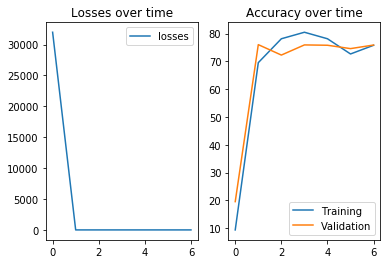

In [45]:
train_subset = 10000
num_steps = 3001
batch_size = 128
beta = 0.1
num_nodes = 1024
losses, train_acc, valid_acc = [],[],[]


graph = tf.Graph()
with graph.as_default():
    # Input data for the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training ReLU layer.
    logits_1 = tf.matmul(tf_train_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    # Dropout on hidden layer: ReLU layer
    keep_prob = tf.placeholder(tf.float32)
    relu_layer_dropout = tf.nn.dropout(relu_layer, 0.5)
    
    logits_2 = tf.matmul(relu_layer_dropout, weights_2)+biases_2
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits_2))    
    loss = tf.reduce_mean(loss + beta * (tf.nn.l2_loss(weights_1)+tf.nn.l2_loss(weights_2)))
    
    # Optimizer
    global_step = tf.Variable(0) # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 10000, 0.8)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training data.
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation data.
    logits_1 = tf.matmul(tf_valid_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test data.
    logits_1 = tf.matmul(tf_test_dataset, weights_1)+biases_1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2)+biases_2
    test_prediction = tf.nn.softmax(logits_2)
     

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step*batch_size)%(train_labels.shape[0]-batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step%500==0):
            losses.append(l)
            print('Loss at step %d: %f' % (step,l))
            acc = accuracy(predictions, batch_labels)
            train_acc.append(acc)
            print('Training accuracy: %0.1f%%' % acc)
            acc= accuracy(valid_prediction.eval(), valid_labels)
            valid_acc.append(acc)
            print('Validation accuracy: %.1f%%' % acc)
            print('.'*25)
    print('test accuracy: %.1f%%' % accuracy(test_prediction.eval(),test_labels))

plt.subplot(1,2,1)
plt.plot(losses)
plt.legend(['losses'])
plt.title('Losses over time')
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy over time')
plt.legend(['Training', 'Validation'])
plt.show()